# Simple Meshing Workflow

This is a simple workflow for generating 1D and 2D meshes.  Note this workflow can do simple 3D meshes as well, especially for simple topography like hexahedral meshes that track a DEM or similar.

Often, even in very simple simulations, we use variable vertical resolution (dz).  For many processes (infiltration vs runoff generation, thermal processes, vegetation) much of the dynamics happens in the very near surface soil (within the top centimeters to meters, or in the critical zone).  That said, groundwater depths or the annual thermal signal can propogate to many meters below the surface.  To resolve the near surface dynamics without using so many cells that the simulation is unnecessarily expensive to run, we often use small dz (\~10cm or less) at the surface and much coarser (\~1-5 m) at depth.

This workflow, and most ATS workflows, make **terrain following, extruded** meshes.  These meshes can be unstructured in map-view, but follow the same vertical spacing everywhere.  This is not required for ATS, but is the most commonly used type of mesh.

Note that an unstructured mesh is completely specified by:
* nodal coordinates
* topology (faces as collections of nodes, cells as collections of faces)
* labeled sets (collections of nodes, faces, or cells)

This workflow uses the "meshing_ats" tool provided with the ATS repository.

## Note on mesh dimensionality

All meshes have two dimensions -- the "spatial" dimension (the dimension of the coordinates of the nodes) and the "manifold" dimension (the dimension of a single cell).  ATS uses:

* 3 space, 3 manifold: standard volumetric mesh in 3D
* 3 space, 2 manifold: the surface of the Earth
* 2 space, 2 manifold: a flattened surface mesh whose z-coordinate has been removed
* 1 space, 1 manifold: very few processes use a true 1D mesh

## Note on labels

Labels must be unique.  Therefore we use the following conventions to make life simpler across all ATS meshes.  This is not _required_, but is strongly encouraged.

* 1 : the bottom boundary faces of the domain
* 2 : the top (surface) boundary faces of the domain
* 3 : all other boundary faces (side boundaries)
* 4-9 : reserved for user-provided sets, e.g. outlets, observation points, etc.
* 10-99 : Land Cover side sets, typically NLCD indices are used directly
* 100 : geologic layer material IDs, e.g. rock types
* 999 : reserved for bedrock
* 1000-9999 : soil layer material IDs, e.g. soil types
* 10000+ : user-defined, no limitations

## Note on format

We write these meshes to ExodusII files.  ExodusII can handle two types of meshes -- "fixed type" meshes, which contain only elements of a given type (e.g. tetrahedrons, hexahedrons, triangular prisms, etc) or "polyhedral meshes."  In the former, faces are not stored -- instead, each cell is a list of nodes ordered in a particular way.  In the latter, faces are stored explicitly as a list of  nodes, and cells are stored as a list of faces.  ATS meshing workflows tend to write the latter, because it is actually simpler, and typed meshes can be stored as polyhedral meshes.

Vis tools like VisIt and Paraview tend to do better with fixed type meshes, however.  If you write a fixed type mesh in polyhedral form, MSTK's `meshconvert` utility can be used to detect and change the type automatically.  This is built and installed with ATS:

    $AMANZI_TPLS_DIR/bin/meshconvert transect.exo transect_fixed_format.exo



In [1]:
import sys,os
sys.path.append(os.path.join(os.environ['ATS_SRC_DIR'],'tools','meshing','meshing_ats'))
import meshing_ats

import numpy as np
from matplotlib import pyplot as plt

Matplotlib created a temporary config/cache directory at /tmp/matplotlib-_2_8z9sb because the default path (/home/ats_sc_user/.cache/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


## Yakou mesh configuration
- 2 - D hillslope transect: [3-D with unit layer thickness]
- Length: 1000 m, slope = 10%, dx = 10 m --> 100 cells (0r 101 nodes)
- Along the vertical profile: Organic layer (0.3 m), Mineral layer (0.3 - 20 m), Bedrock (20 – 40 m) [1001, 1002, 999]

### Developing the top sloping surface:

# of x and z coordinates: (101, 101)
# of cells: 100


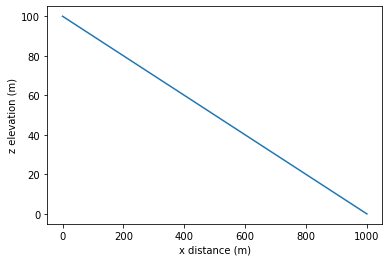

In [8]:
# The top surface is given by z(x):

# Generating the x-coordinates with 10 m spacing
x = np.linspace(0, 1000, 101)
#print(x)

# Generating the sloping z-coordinates
z = 100 - 0.1*x # 0.1 or 10% slope 
#print(z)

print(f'# of x and z coordinates: {len(x),len(z)}')

# Plot the surface topography 
plt.plot(x,z);plt.xlabel('x distance (m)'); plt.ylabel('z elevation (m)')

# Generate the manifold 2D mesh.
m2 = meshing_ats.Mesh2D.from_Transect(x,z)
print(f'# of cells: {m2.num_cells()}')

### Generating the vertical column
- Three types of soil: Organic-rich layer (0.25 m), Mineral layer (0.25 - 20 m), and Bedrock (20 – 40 m) [1001, 1002, 999]

In [20]:
# Prepare layer extrusion data
#
# Meshes are extruded in the vertical by "layer", where a layer may 
# consist of multiple cells in the z direction.  These layers are 
# logical units to make construction easier, and may or may not 
# correspond to material type (organic/mineral soil).
# 
# The extrusion process is then given four lists, each of length
# num_layers.
#
layer_types = []  # a list of strings that tell the extruding 
                  # code how to do the layers.  See meshing_ats 
                  # documentation for more, but here we will use
                  # only "constant", which means that dz within
                  # the layer is constant.

layer_data = []   # this data depends upon the layer type, but
                  # for constant is the total thickness of the layer

layer_ncells = [] # number of cells (in the vertical) in the layer.
                  # The dz of each cell is the layer thickness / number of cells.

layer_mat_ids = []# The material ID.  This may be either a constant int (for
                  # unform layering) or an array of size [ncells_vertical x ncells_horizontal] in the layer 
                  # where each entry corresponds to the material ID of that cell.
        

# A.Organic-rich layer (1001): A single layer, 5 cells @ 0.05 m = 0.25 m of organic soil
layer_types.append("constant")
layer_data.append(0.25)
layer_ncells.append(5)
layer_mat_ids.append(1001) 
current_depth = 0.25

# B.Mineral soil layer (1002) from 0.25 m to 2 m: Two units - 
# 1. 5 cells @ 0.05 m = 0.25 m of first part mineral soil [0.25 - 0.5 m]
# 2. Increasing dz by a factor of 2 until 2 m [0.5 m - 2 m]
# 3. Adding dz = 2 m until 20 m [2 m - 20 m]

# 1. 5 cells @ 0.05 m = 0.25 m of first part mineral soil [0.25 - 0.5 m]
layer_types.append('constant')
layer_data.append(0.25)
layer_ncells.append(5)
layer_mat_ids.append(1002)
current_depth += 0.25

# 2. Increasing dz by a factor of 2 until 2 m [0.6 m - 2 m]
dz = 0.05
i = 0

while current_depth < 2:
    dz *= 2
    layer_types.append("constant")
    layer_data.append(dz)
    layer_ncells.append(1)
    layer_mat_ids.append(1002)
    current_depth += dz
    i += 1
    
# 3. Adding dz = 2 m until 20 m [2 m - 20 m]
layer_types.append('constant')
layer_data.append(18)
layer_ncells.append(18//2)
layer_mat_ids.append(1002)
current_depth += 19.9

print(f"The depth after mineral layer: current_depth = {current_depth}, dz = {dz} ")

# C. Bedrock (999) - Adding several cells with 2 m thickness (dz) from 2 m - 40 m
layer_types.append("constant")
layer_data.append(20)
layer_ncells.append(20//2)
layer_mat_ids.append(999)
current_depth += 20

# Adding the last point until 40 m
#layer_types.append("constant")
#layer_data.append(40)
#layer_ncells.append(1)
#layer_mat_ids.append(999)
#current_depth += 1.9

# Summary of the vertical column

meshing_ats.summarize_extrusion(layer_types, layer_data, layer_ncells, layer_mat_ids)

The depth after mineral layer: current_depth = 21.9, dz = 0.8 
Cell summary:
------------------------------------------------------------
l_id	| c_id	|mat_id	| dz		| z_top
------------------------------------------------------------
 00 	| 00 	| 1001 	|   0.050000 	|   0.000000
 00 	| 01 	| 1001 	|   0.050000 	|   0.050000
 00 	| 02 	| 1001 	|   0.050000 	|   0.100000
 00 	| 03 	| 1001 	|   0.050000 	|   0.150000
 00 	| 04 	| 1001 	|   0.050000 	|   0.200000
 01 	| 05 	| 1002 	|   0.050000 	|   0.250000
 01 	| 06 	| 1002 	|   0.050000 	|   0.300000
 01 	| 07 	| 1002 	|   0.050000 	|   0.350000
 01 	| 08 	| 1002 	|   0.050000 	|   0.400000
 01 	| 09 	| 1002 	|   0.050000 	|   0.450000
 02 	| 10 	| 1002 	|   0.100000 	|   0.500000
 03 	| 11 	| 1002 	|   0.200000 	|   0.600000
 04 	| 12 	| 1002 	|   0.400000 	|   0.800000
 05 	| 13 	| 1002 	|   0.800000 	|   1.200000
 06 	| 14 	| 1002 	|   2.000000 	|   2.000000
 06 	| 15 	| 1002 	|   2.000000 	|   4.000000
 06 	| 16 	| 1002 	|   2.000000

### make the 2-D mesh, save it as an exodus file

In [21]:
m3 = meshing_ats.Mesh3D.extruded_Mesh2D(m2, layer_types,layer_data, 
                                        layer_ncells, layer_mat_ids)
if os.path.exists('yakou_hillslope.exo'):
    os.remove('yakou_hillslope.exo')
m3.write_exodus('yakou_hillslope.exo')

Opening exodus file: yakou_hillslope.exo
Closing exodus file: yakou_hillslope.exo


### Make the 1-D column, save it as an exodus file

In [23]:
# Making the surface mesh that is a 1 m X 1 m box in the map view

m2c = meshing_ats.Mesh2D.from_Column(0., 0., 0., width=1)
print(f"# of cells: {m2c.num_cells()}")

# of cells: 1


In [24]:
# Turn this into a 3D mesh (column of cells), and save it to disk
m3c = meshing_ats.Mesh3D.extruded_Mesh2D(m2c, layer_types, layer_data, layer_ncells, layer_mat_ids)
if os.path.exists('yakou_column.exo'):
    os.remove('yakou_column.exo')
m3c.write_exodus('yakou_column.exo')

Opening exodus file: yakou_column.exo
Closing exodus file: yakou_column.exo
